In [1]:
import pandas as pd
import numpy as np
import models_and_functions as MyModels
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from torchdiffeq import odeint
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
df_antibiotics, antibiotic_types, df_relative_abundances= MyModels.wrangle_data()
df_relative_abundances = df_relative_abundances.drop_duplicates(subset = ['PatientID', 'DayRelativeToNearestHCT'])
node_model = torch.load('node_model.pth', weights_only=False)
test_df = pd.read_csv('node_model_test_df.csv', index_col = 0)


enterococcus_infections = ['Enterococcus_Faecium',
                           'Enterococcus_Faecium_Vancomycin_Resistant',
                           'Enterococcus_Vancomycin_Resistant',
                           'Enterococcus_Faecalis']

gammmaproteobacteria_infections = ['Escherichia',
                                  'Pseudomonas',
                                  'Klebsiella',
                                  'Klebsiella_Pneumoniae',
                                  'Enterobacter',
                                  'Stenotrophomonas_Maltophilia',
                                  'Citrobacter']


df_infections = pd.read_csv('tblInfectionsCidPapers.csv')
df_bacilli_infections = df_infections[df_infections['InfectiousAgent'].isin(enterococcus_infections)]
df_gammaproteobacteria_infections = df_infections[df_infections['InfectiousAgent'].isin(gammmaproteobacteria_infections)]

glv_model = torch.load('glv_model.pth', weights_only = False)
glv_test_df = pd.read_csv('glv_model_test_df.csv', index_col = False)
glv_test_df_relative_abundances = test_df[test_df['SampleID'].isin(glv_test_df['SampleID'].unique())]



CUDA is available. Using GPU.
GPU Device name: NVIDIA A100 80GB PCIe
GPU Memory Allocated: 0.0 GB
GPU Memory Cached: 0.0 GB


/data1/xavierj/isaac/Neural_ODEs_Paper_Code_2/Clinical_Data_Experiments/models_and_functions.py:31: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print(f"GPU Memory Cached: {round(torch.cuda.memory_cached(0)/1024**3,1)} GB")


In [2]:
# First, create a ground truth prediction function that works for multiple ranges
def make_infection_predictions_ground_truth_multiple_ranges(model, test_df, index_of_taxa = 2, 
                               number_of_taxa = 'reduced', 
                               aggregate_statistic = 'mean', convert_to_relative_abundances = False):
    
    print('computing infection predictions using ground truth measurements...')
    
    if index_of_taxa == 2:
        infections_df = df_bacilli_infections
        name_of_class = 'Bacilli'
    if index_of_taxa == 9:
        infections_df = df_gammaproteobacteria_infections
        name_of_class = 'Gammaproteobacteria'
    
    # Dictionary to store predictions for each range (1 to 100 days)
    predictions_by_range = {range_days: [] for range_days in range(1, 101)}
    
    for patient_id in test_df['PatientID'].unique():
        # get the trajectory data for patient_id's timeline
        t_preds, t_true, y_trues, true_indices = MyModels.get_data(test_df, patient_id, number_of_taxa = number_of_taxa)
        
        # Get patient's data from test_df
        patient_data = test_df[test_df['PatientID'] == patient_id].copy()
        
        for i in range(len(t_true)-1):
            # start of prediction window
            t_start = t_true[i]
            y0 = y_trues[i]
            t_start_np = t_start.cpu().numpy()
            
            # Initial abundance level
            initial_bacilli_abundance_level = np.float64(y0[index_of_taxa].cpu().detach().item())
            
            # Get actual infection times for this patient
            actual_infection_times = list(infections_df[infections_df['PatientID']==patient_id]['DayRelativeToNearestHCT'])
            
            # For each range from 1 to 100 days
            for range_days in range(1, 101):
                t_end_np = t_start_np + range_days
                
                # Get measurements in the prediction window
                window_mask = (patient_data['DayRelativeToNearestHCT'] > t_start_np) & \
                             (patient_data['DayRelativeToNearestHCT'] <= t_end_np)
                window_data = patient_data[window_mask].sort_values('DayRelativeToNearestHCT')
                
                if len(window_data) == 0:
                    # Skip this prediction if no ground truth data available in window
                    continue
                    
                # Get the taxa values from the ground truth data
                taxa_column = test_df.columns[index_of_taxa]
                taxa_measurements = window_data[taxa_column].values
                measurement_times = window_data['DayRelativeToNearestHCT'].values
                
                # Convert to relative abundances if requested
                if convert_to_relative_abundances:
                    taxa_cols = [col for col in test_df.columns if col not in ['PatientID', 'DayRelativeToNearestHCT']]
                    window_taxa_data = window_data[taxa_cols].values
                    row_sums = np.sum(window_taxa_data, axis=1)
                    normalized_data = window_taxa_data / row_sums[:, np.newaxis]
                    taxa_measurements = normalized_data[:, index_of_taxa]
                
                # Remove any NaN values (and corresponding times)
                valid_mask = ~np.isnan(taxa_measurements)
                taxa_measurements = taxa_measurements[valid_mask]
                measurement_times = measurement_times[valid_mask]
                
                if len(taxa_measurements) == 0:
                    continue
                
                # Calculate aggregate statistic
                if aggregate_statistic == 'max':
                    taxa_pred_summary_abundance_level = np.max(taxa_measurements)
                elif aggregate_statistic == 'mean':
                    # Calculate time-weighted mean
                    if len(taxa_measurements) == 1:
                        taxa_pred_summary_abundance_level = taxa_measurements[0]
                    else:
                        # Calculate weights based on time intervals
                        weights = np.zeros(len(taxa_measurements))
                        
                        weights[0] = (measurement_times[0] - t_start_np) + \
                                     (measurement_times[1] - measurement_times[0]) / 2
                        
                        for j in range(1, len(taxa_measurements) - 1):
                            weights[j] = (measurement_times[j] - measurement_times[j-1]) / 2 + \
                                        (measurement_times[j+1] - measurement_times[j]) / 2
                        
                        weights[-1] = (measurement_times[-1] - measurement_times[-2]) / 2 + \
                                      (t_end_np - measurement_times[-1])
                        
                        # Calculate weighted mean
                        taxa_pred_summary_abundance_level = np.average(taxa_measurements, weights=weights)
                
                # Check if infection occurred within this range
                actual_infection = int(any((t_start_np <= t < t_start_np + range_days) for t in actual_infection_times))
                
                predictions_by_range[range_days].append([
                    taxa_pred_summary_abundance_level, 
                    actual_infection, 
                    initial_bacilli_abundance_level
                ])
    
    # Convert lists to numpy arrays and remove NaN rows
    for range_days in range(1, 101):
        print(range_days)
        abundance_predictions = np.array(predictions_by_range[range_days])
        # remove rows with NAN
        abundance_predictions = abundance_predictions[~np.isnan(abundance_predictions).any(axis=1)]
        predictions_by_range[range_days] = abundance_predictions
    
    print('done computing infection predictions from ground truth')
    return predictions_by_range

# Generate ground truth predictions
ground_truth_dict = make_infection_predictions_ground_truth_multiple_ranges(node_model, test_df)


computing infection predictions using ground truth measurements...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
done computing infection predictions from ground truth


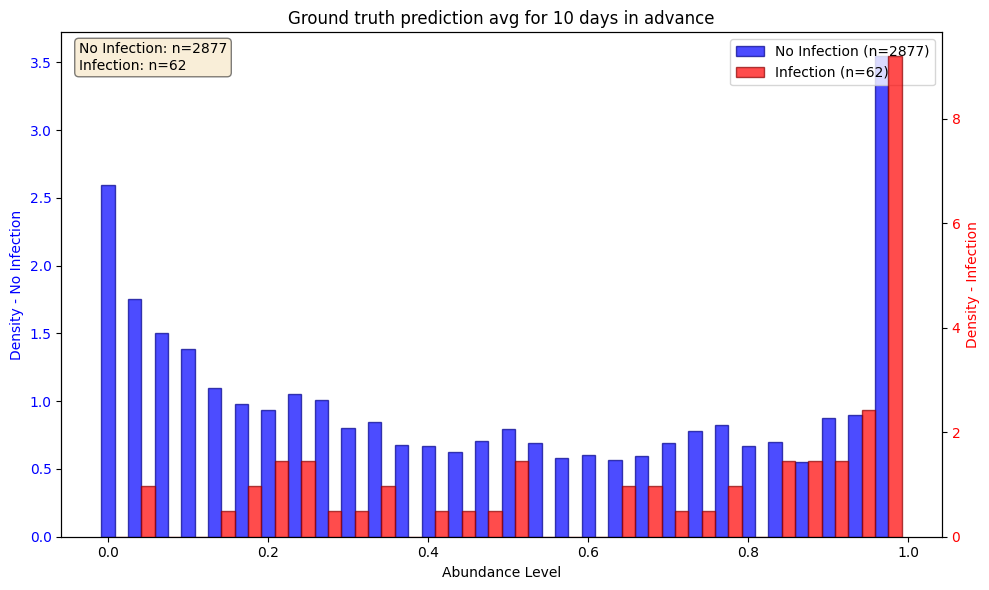

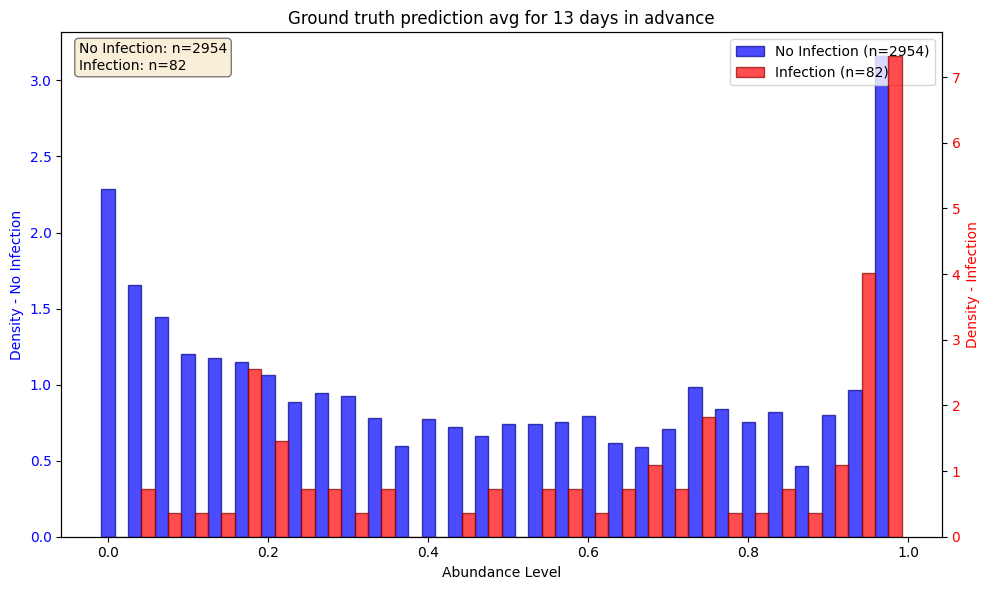

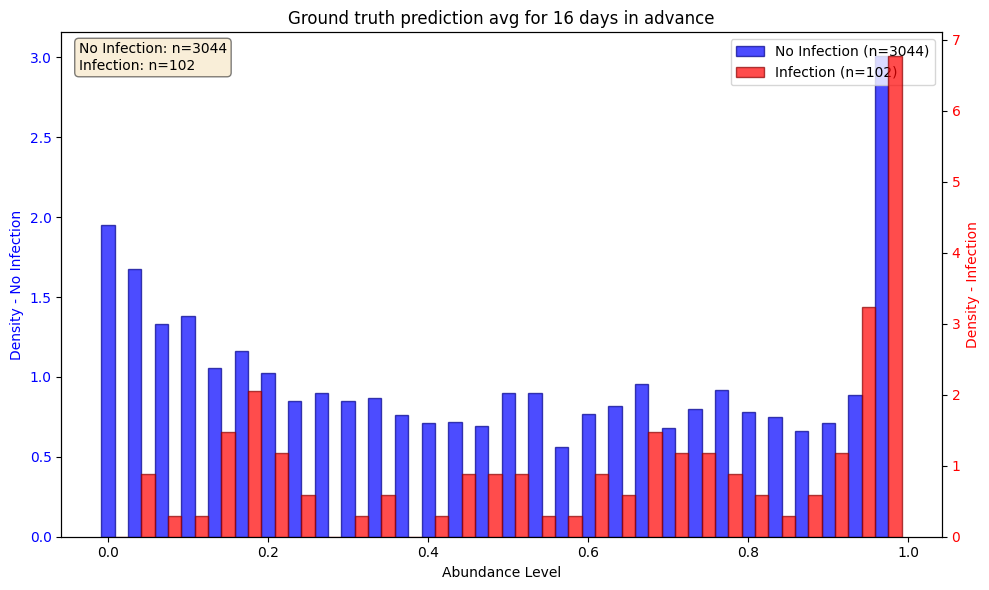

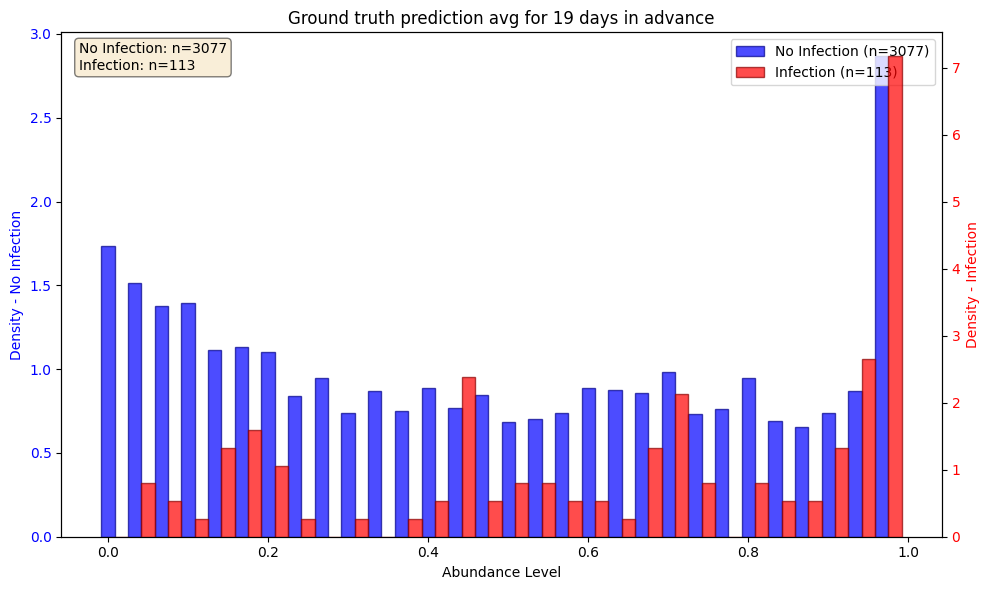

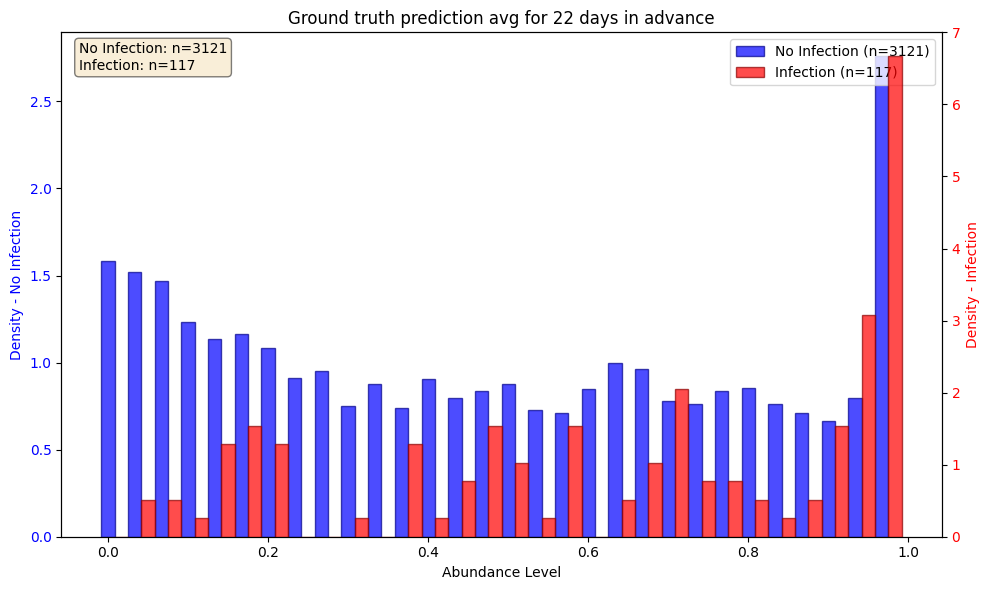

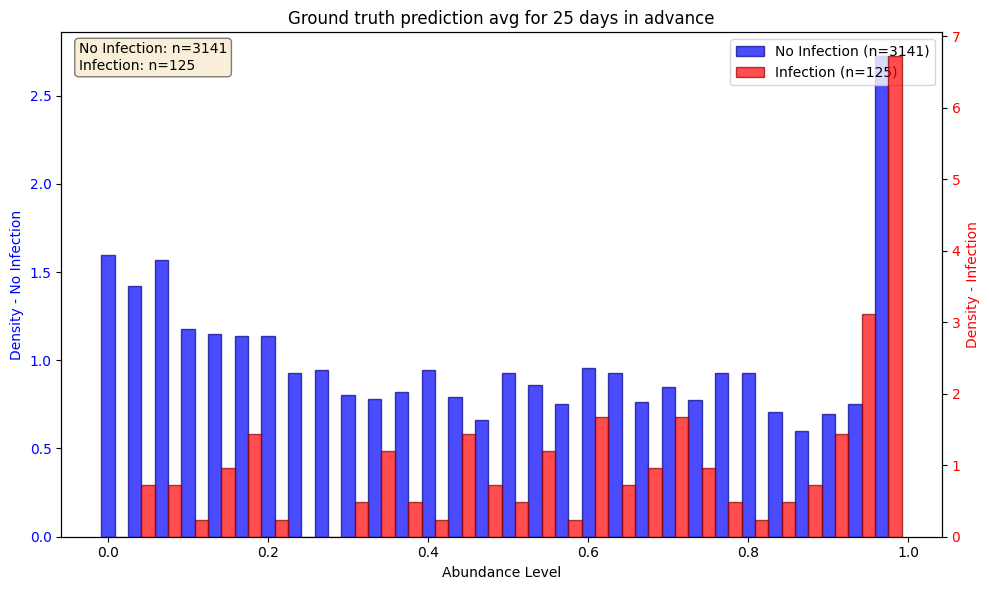

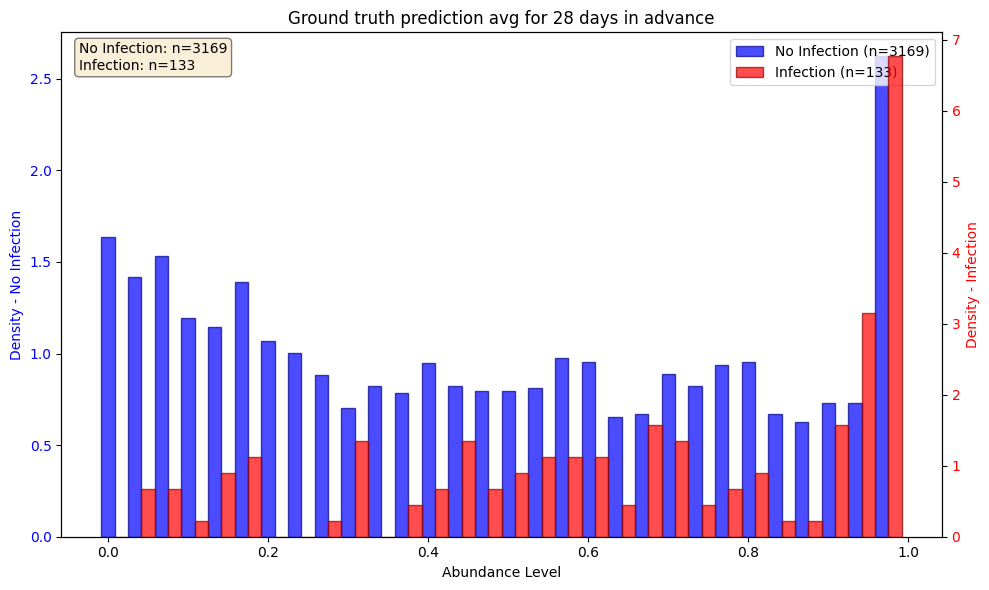

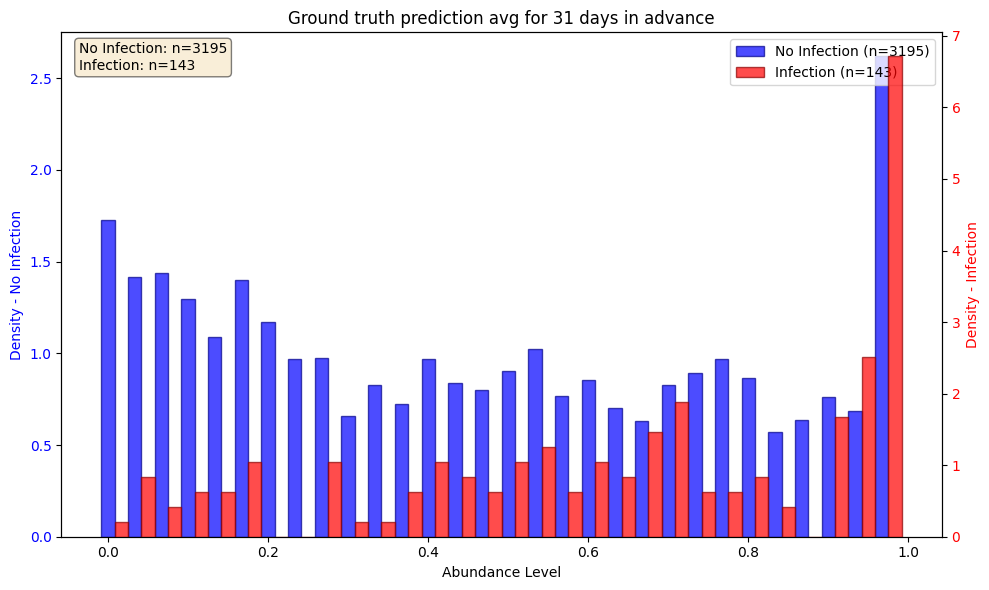

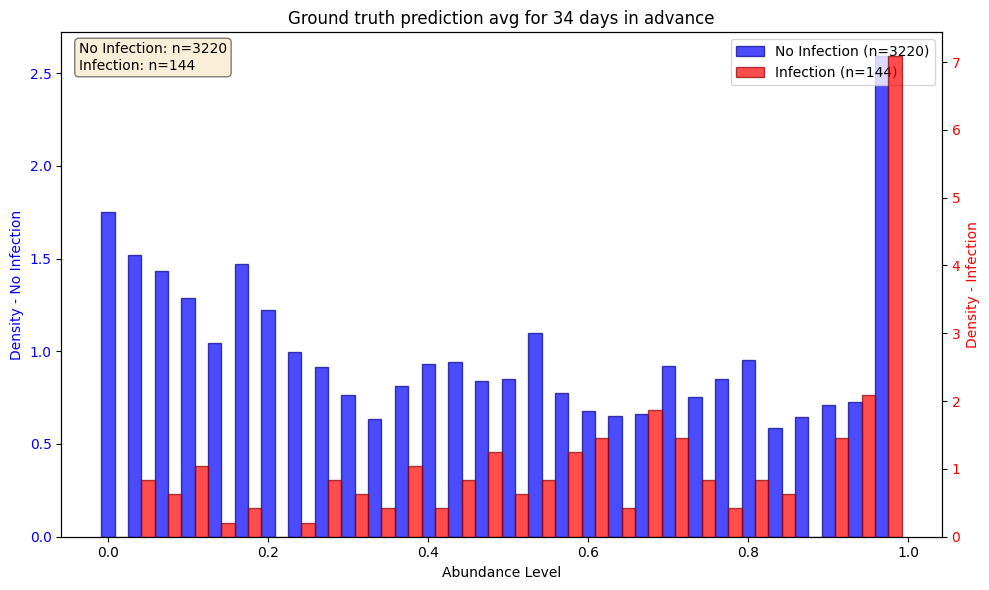

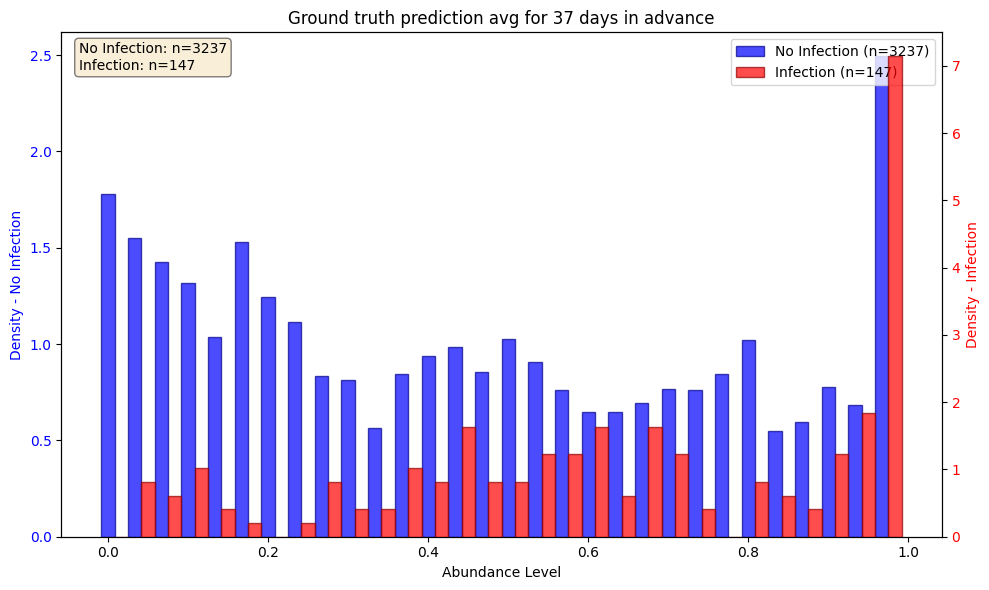

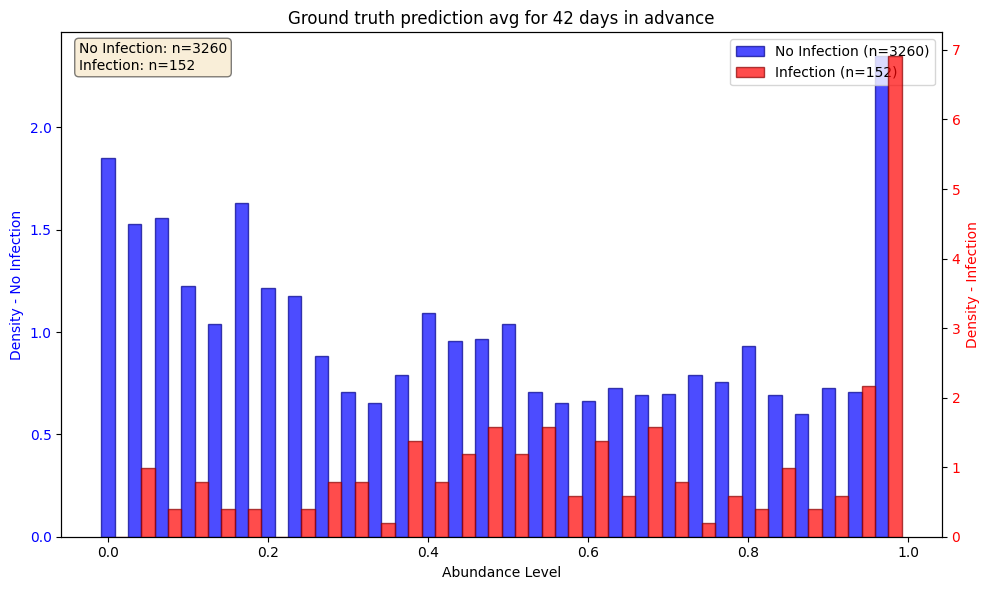

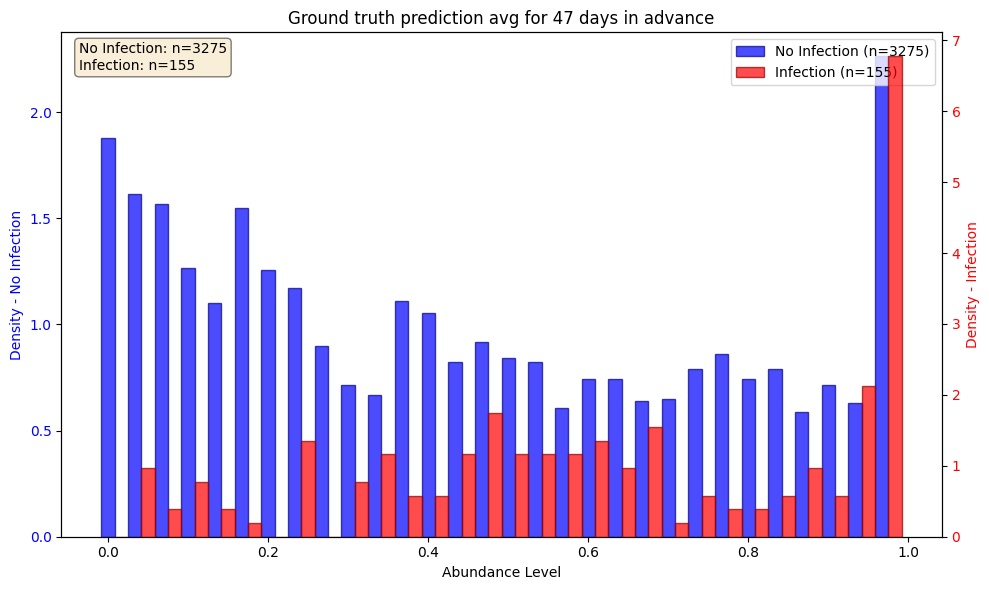

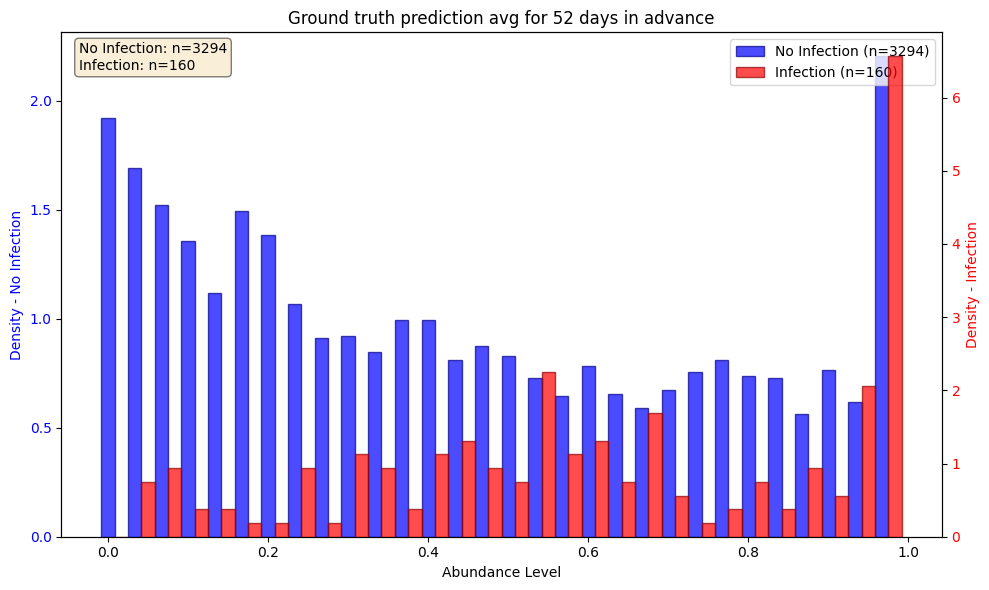

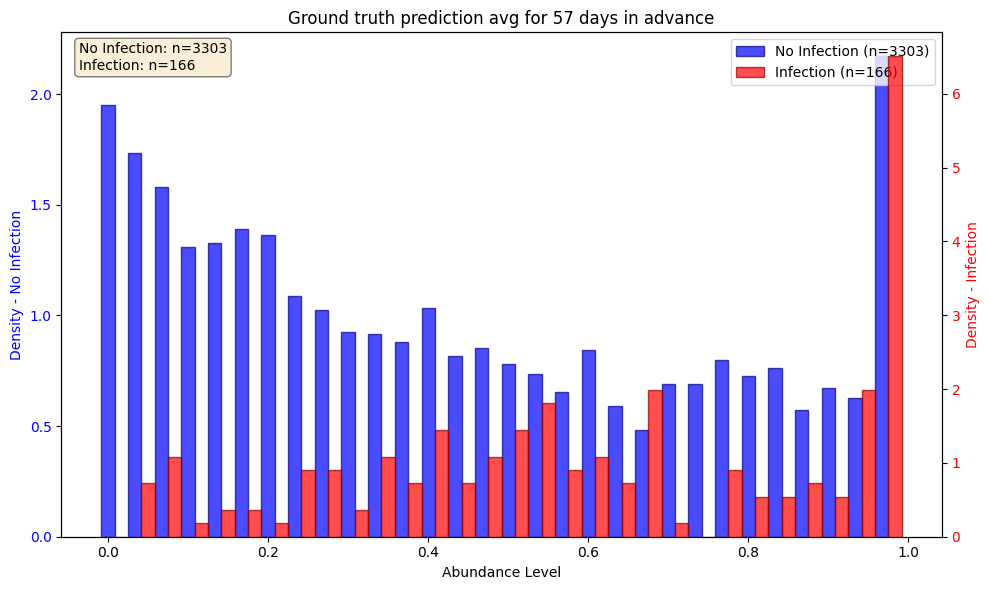

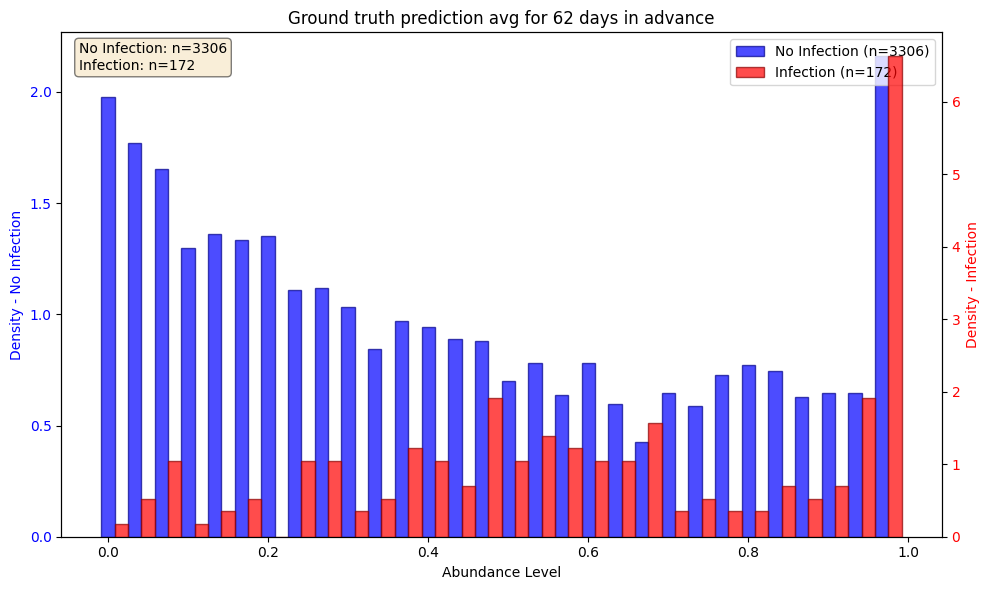

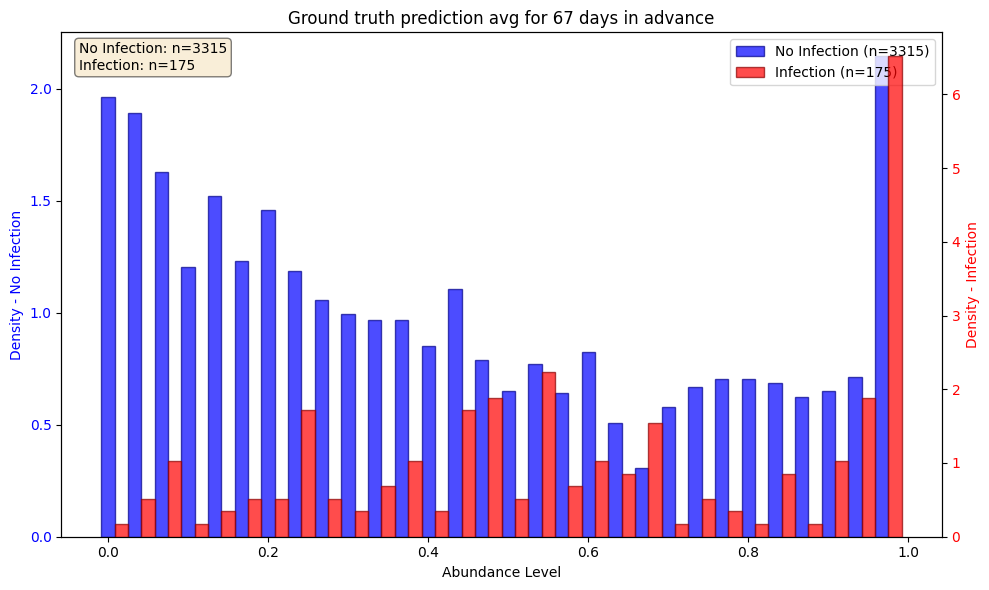

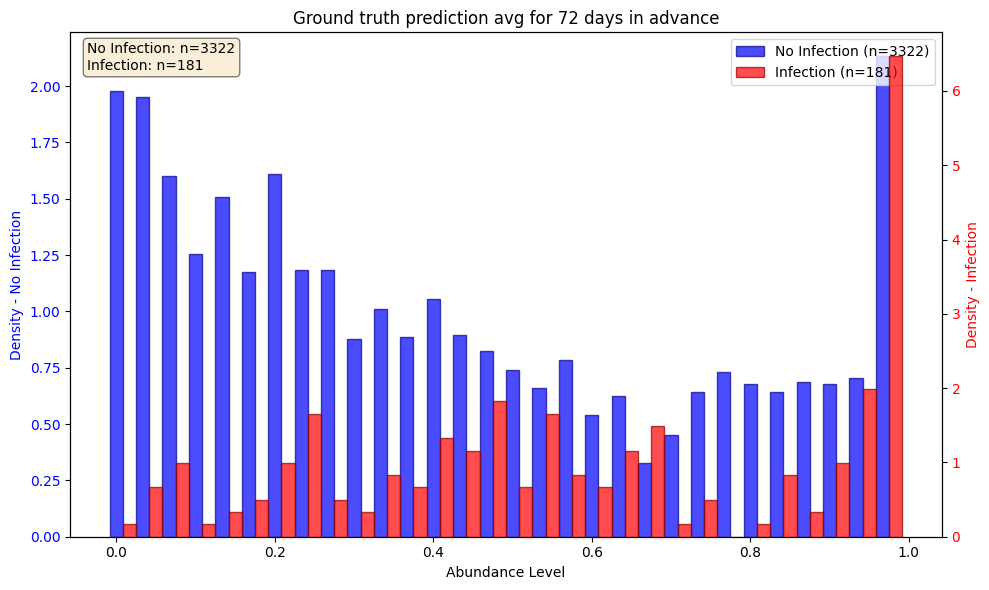

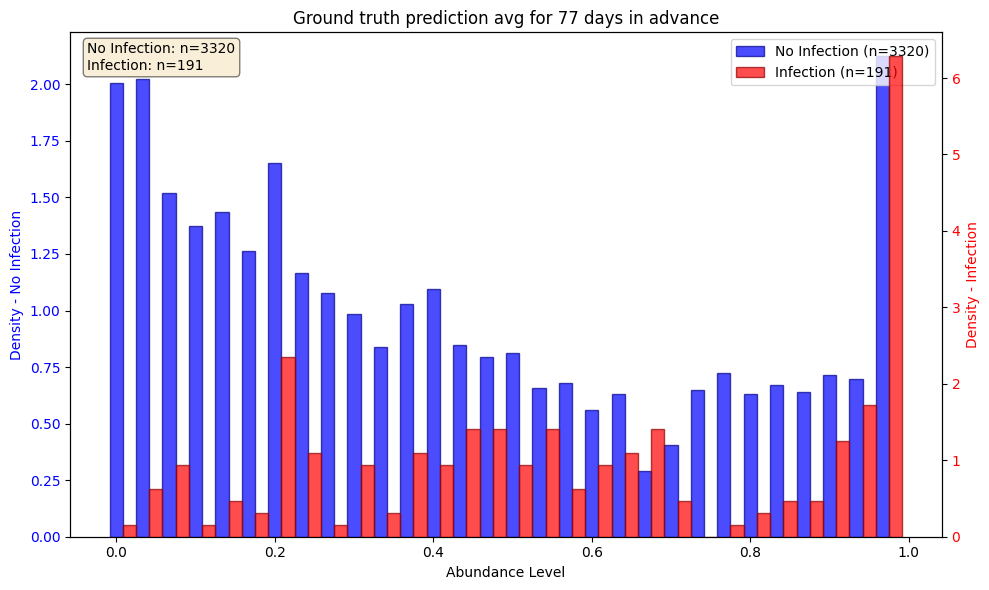

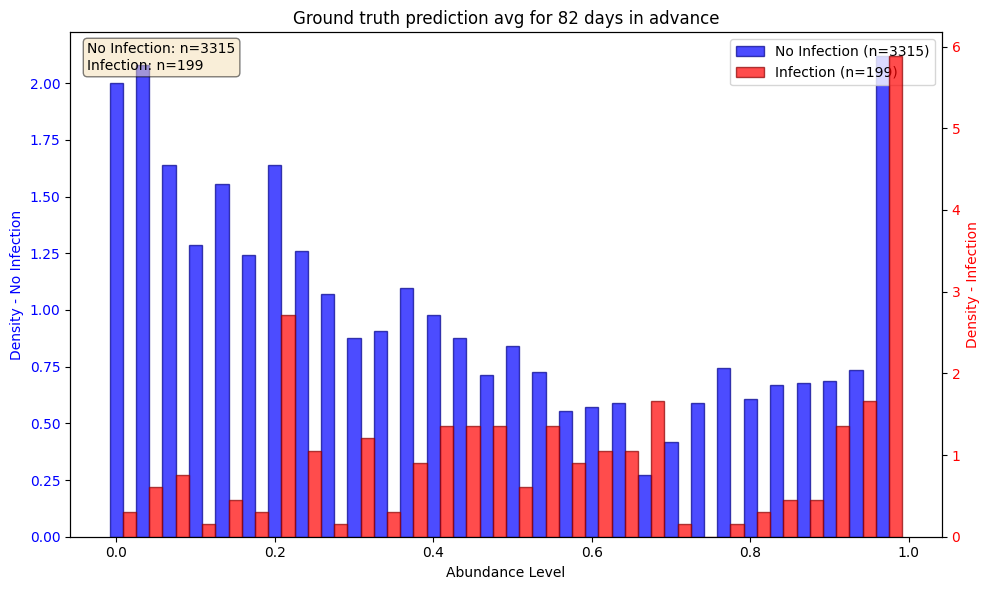

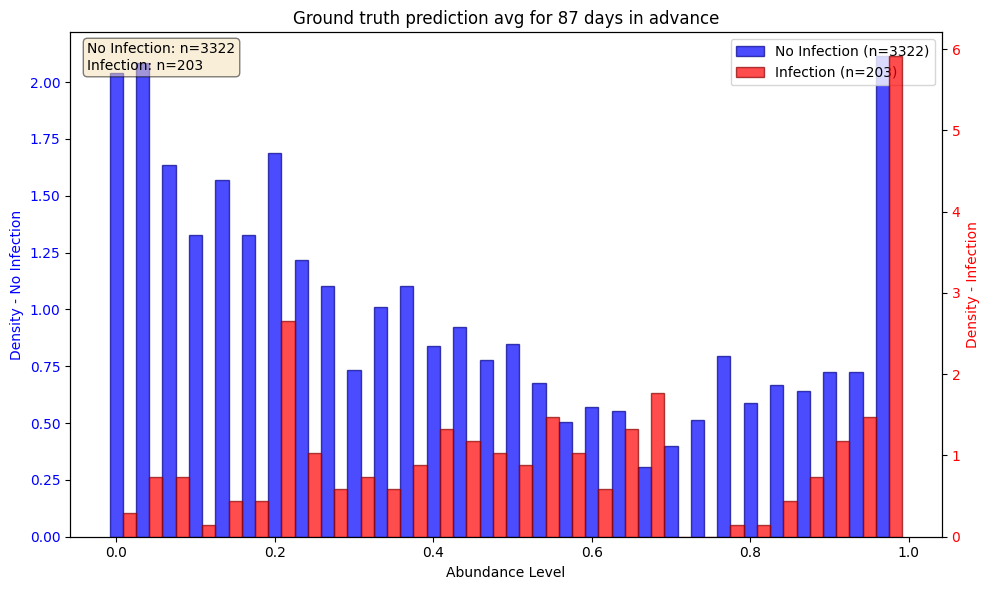

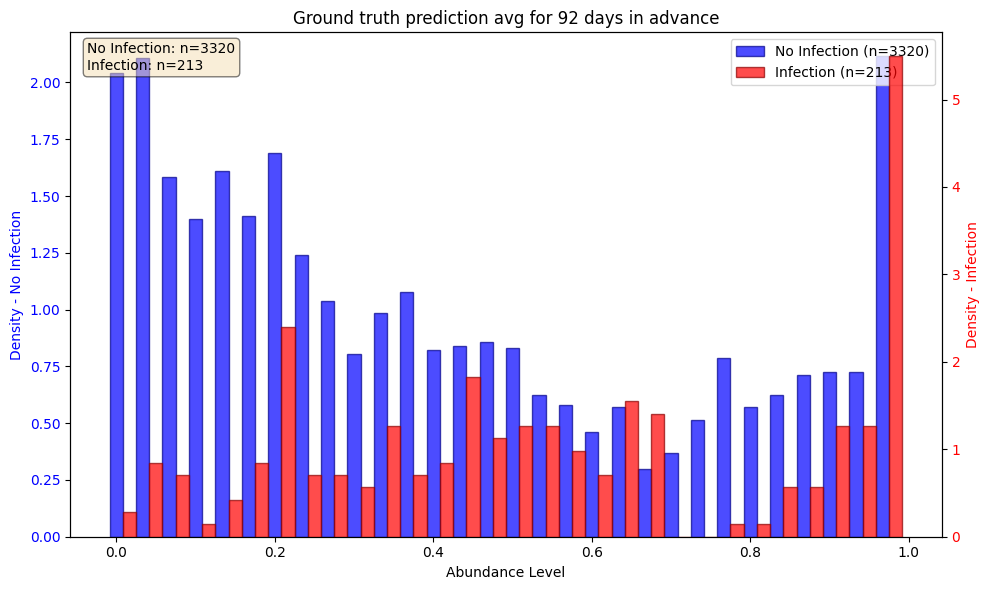

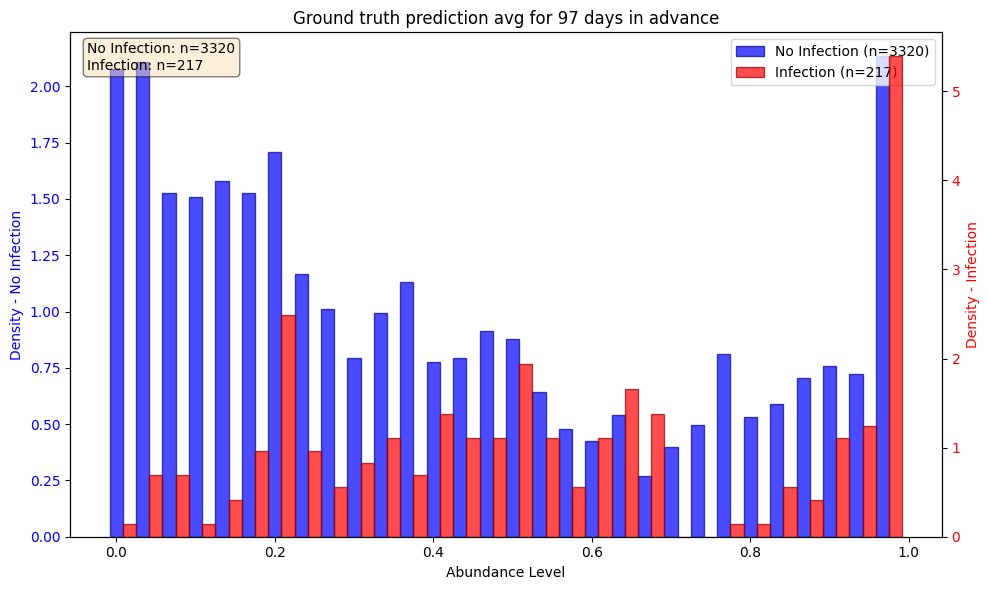

In [4]:

# Create histograms for ground truth data with normalized areas and dual y-axes
for i in list(range(10, 40, 3)) + list(range(42, 100, 5)):
    abundance_predictions = ground_truth_dict[i]
    
    # Separate data by category
    cat0_data = abundance_predictions[abundance_predictions[:, 1] == 0, 0]
    cat1_data = abundance_predictions[abundance_predictions[:, 1] == 1, 0]
    
    n_cat0 = len(cat0_data)
    n_cat1 = len(cat1_data)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Create shared bins for both categories
    all_data = np.concatenate([cat0_data, cat1_data])
    bins = np.histogram_bin_edges(all_data, bins=30)
    bin_width = bins[1] - bins[0]
    
    # Calculate histogram values for both categories
    counts0, _ = np.histogram(cat0_data, bins=bins, density=True)
    counts1, _ = np.histogram(cat1_data, bins=bins, density=True)
    
    # Plot category 0 bars shifted to the left
    ax1.bar(bins[:-1] - bin_width/4, counts0, width=bin_width/2, 
            color='blue', alpha=0.7, label=f'No Infection (n={n_cat0})', 
            edgecolor='darkblue', align='edge')
    ax1.set_ylabel('Density - No Infection', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Create second y-axis for category 1
    ax2 = ax1.twinx()
    # Plot category 1 bars shifted to the right
    ax2.bar(bins[:-1] + bin_width/4, counts1, width=bin_width/2, 
            color='red', alpha=0.7, label=f'Infection (n={n_cat1})', 
            edgecolor='darkred', align='edge')
    ax2.set_ylabel('Density - Infection', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Add title and x-label
    ax1.set_xlabel('Abundance Level')
    ax1.set_title(f'Ground truth prediction avg for {i} days in advance')
    
    # Add sample counts as text on the plot
    ax1.text(0.02, 0.98, f'No Infection: n={n_cat0}\nInfection: n={n_cat1}', 
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()

In [5]:
def make_infection_predictions(model, test_df, index_of_taxa = 2, 
                               number_of_taxa = 'reduced', method = 'euler', 
                               aggregate_statistic = 'mean', convert_to_relative_abundances = False):
    
    print('computing infection predictions...')
    
    if index_of_taxa == 2:
        infections_df = df_bacilli_infections
        name_of_class = 'Bacilli'
    if index_of_taxa == 9:
        infections_df = df_gammaproteobacteria_infections
        name_of_class = 'Gammaproteobacteria'
    
    # Dictionary to store predictions for each range (1 to 100 days)
    predictions_by_range = {range_days: [] for range_days in range(1, 101)}
    
    for patient_id in test_df['PatientID'].unique():
        model.patient_id = patient_id
        # get the trajectory data for patient_id's timeline
        t_preds, t_true, y_trues, true_indices = MyModels.get_data(test_df, patient_id, number_of_taxa = number_of_taxa)
        print(patient_id)
        for i in range(len(t_true)-1):
            # start of predicted trajectory
            t_start = t_true[i]
            y0 = y_trues[i]
            t_end = t_start + 100  # Predict 100 days ahead
            t_preds = torch.linspace(t_start, t_end, int((t_end-t_start)*3)).to(device)
            
            # Compute NODE prediction once for 100 days
            y_pred_trajectory = odeint(model, y0, t_preds, method=method)
            
            # if the model is glv
            if convert_to_relative_abundances:
                y0 = torch.nn.functional.normalize(torch.clamp(y0, min=0), p=1, dim=0)
                y_pred_trajectory = torch.nn.functional.normalize(torch.clamp(y_pred_trajectory, min=0), p=1, dim=1)

            taxa_pred_trajectory = y_pred_trajectory[:, index_of_taxa]
            actual_infection_times = list(infections_df[infections_df['PatientID']==patient_id]['DayRelativeToNearestHCT'])
            t_start_cpu = t_start.cpu().numpy()
            initial_bacilli_abundance_level = np.float64(y0[index_of_taxa].cpu().detach().item())
            
            # For each range from 1 to 100 days
            for range_days in range(1, 101):
                # Determine which time points fall within this range
                t_preds_cpu = t_preds.cpu().numpy()
                mask = (t_preds_cpu >= t_start_cpu) & (t_preds_cpu <= t_start_cpu + range_days)
                taxa_pred_in_range = taxa_pred_trajectory[mask]
                
                # Compute aggregate statistic for this range
                if aggregate_statistic == 'max':
                    taxa_pred_summary_abundance_level = np.float64(torch.max(taxa_pred_in_range).item())
                elif aggregate_statistic == 'mean':
                    taxa_pred_summary_abundance_level = np.float64(torch.mean(taxa_pred_in_range).item())
                
                # Check if infection occurred within this range
                actual_infection = int(any((t_start_cpu <= t < t_start_cpu + range_days) for t in actual_infection_times))
                
                predictions_by_range[range_days].append([
                    taxa_pred_summary_abundance_level, 
                    actual_infection, 
                    initial_bacilli_abundance_level
                ])
    
    # Convert lists to numpy arrays and remove NaN rows
    for range_days in range(1, 101):
        print(range_days)
        abundance_predictions = np.array(predictions_by_range[range_days])
        # remove rows with NAN
        abundance_predictions = abundance_predictions[~np.isnan(abundance_predictions).any(axis=1)]
        predictions_by_range[range_days] = abundance_predictions
    
    print('done computing infection predictions')
    return predictions_by_range

node_dict = make_infection_predictions(node_model, test_df)


computing infection predictions...
1001
1008
1009
1012
1015
1021
1024
1037
104
1044
1045
1049
1053
1063
1075
1080
1097
1107
1119
1124
1128
114
1141
1143
1144
1147
1151
1156
1158
116
1160
1171
1173
1174
118
1193
1196
120
1201
1203
1207
1208
1209
1210
1220
1229
123
124
1244
1245
1249
125
1251
1252
126
1261
1262
1270
1271
1276
128
1293
130
1303
1305
1312
1316
1331
1333
1338
1341
1345
1347
136
1362
1364
1366
137
1379
1380
1381
139
1393
1398
1400
1414
142
1425
143
1431
1443
1452
146
1461
1479
1491
1498
151
1513
1520
1530
1533
154
1552
156
1564
1569
157
1580
1581
162
164
1644
1648
1663
1686
1691
1708
1711
1713
1716
1721
173
1730
1751
1757
1760
177
1777
1785
1816
182
1826
1833
1838
184
1842
1844
1846
1855
1856
1858
186
187
1876
1881
1885
1891
1893
190
1902
1908
1921
1928
1934
194
1953
1957
1959
1965
1966
1987
199
1995
2000
2023
2029
204
2042
2054
206
2065
2066
207
2070
2081
209
2090
210
2104
2105
2111
2126
2127
2144
2163
218
2180
2196
220
221
226
235
236
238
245
251
266
267
270
271
275
276
27

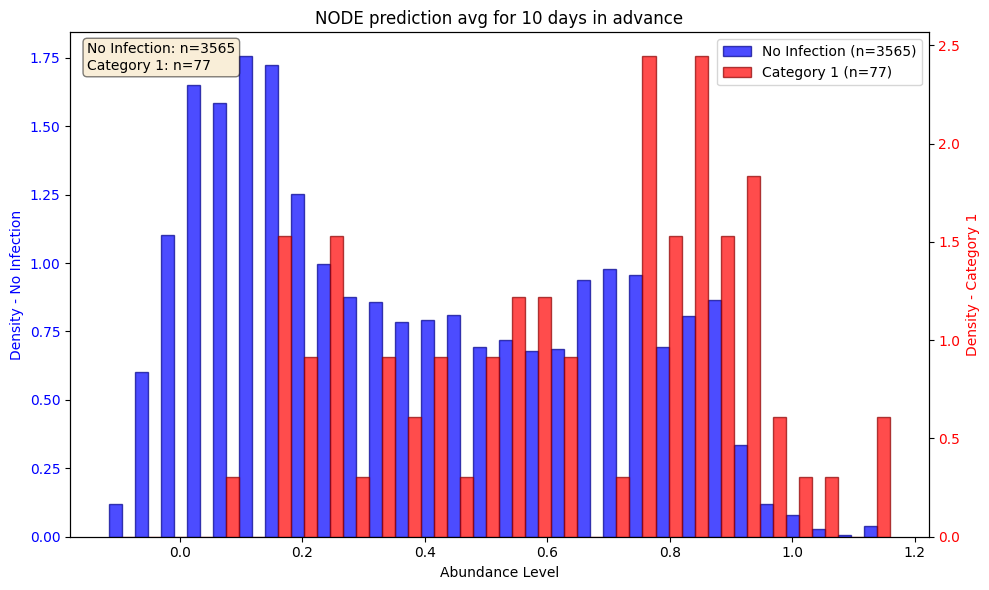

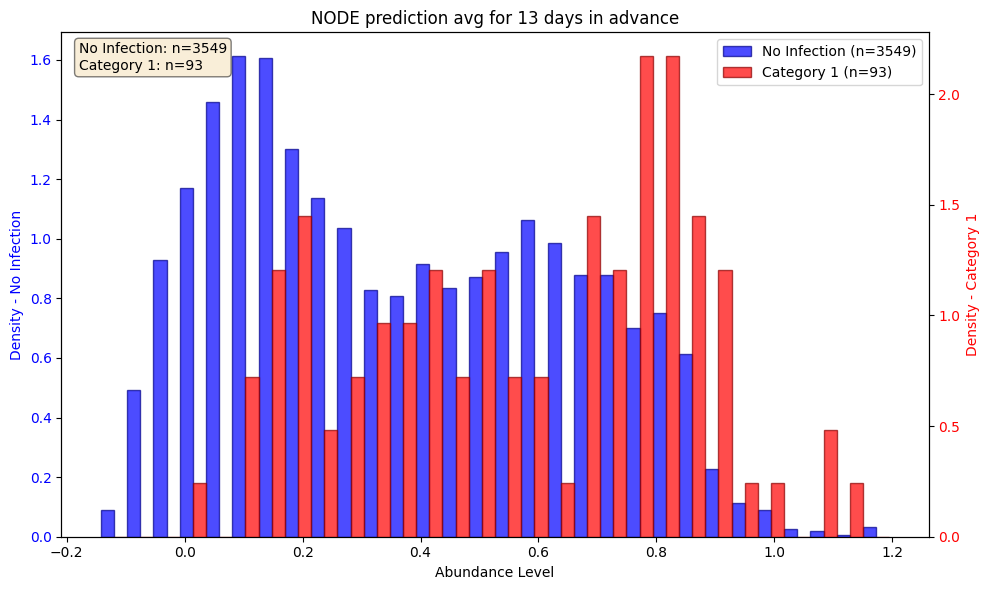

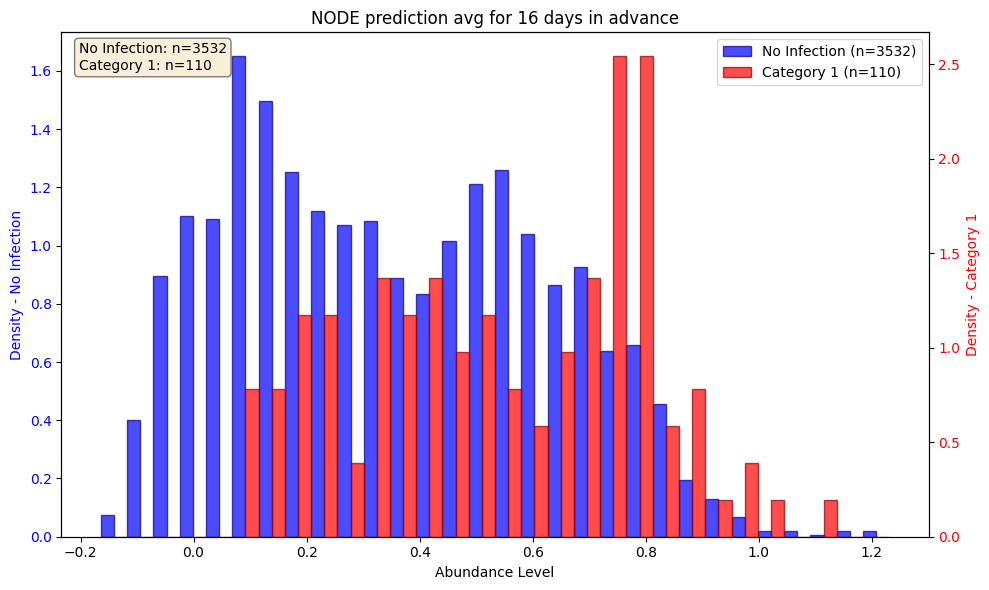

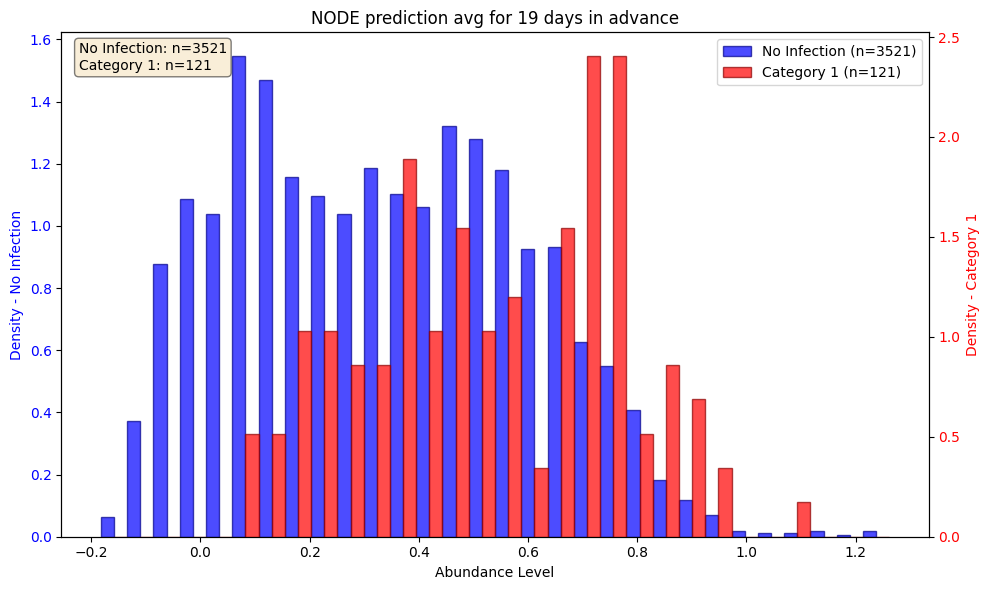

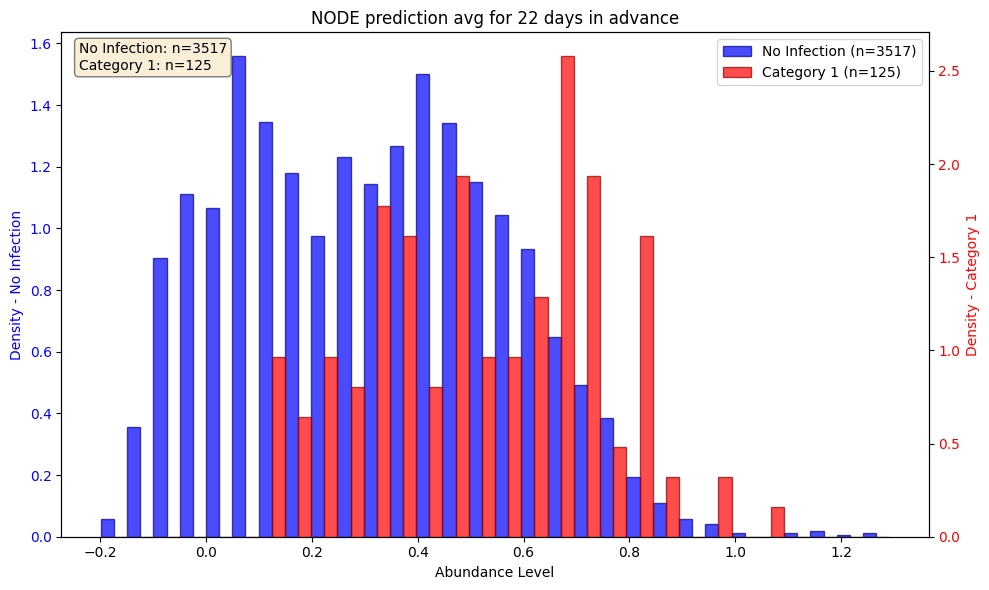

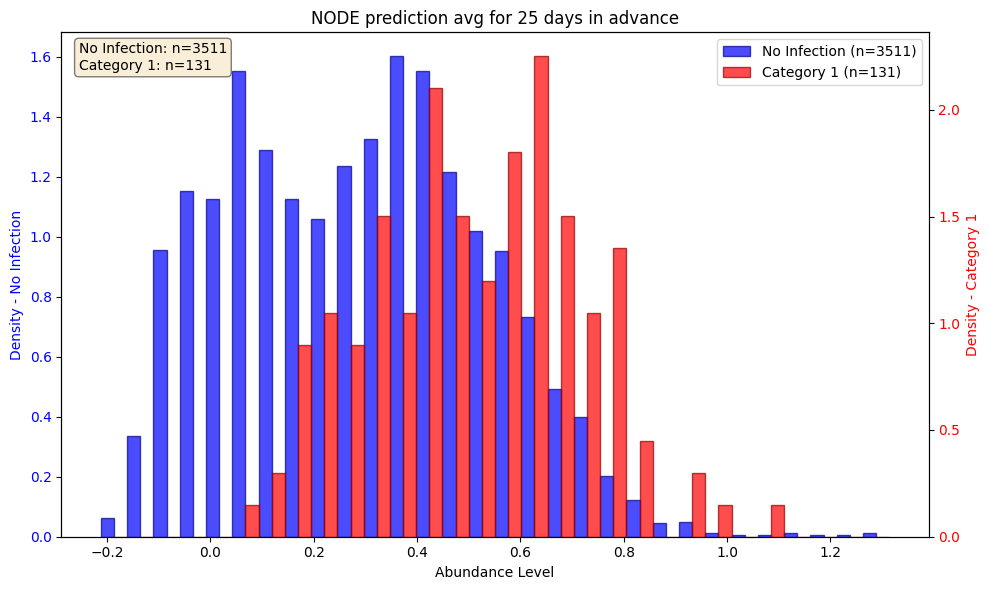

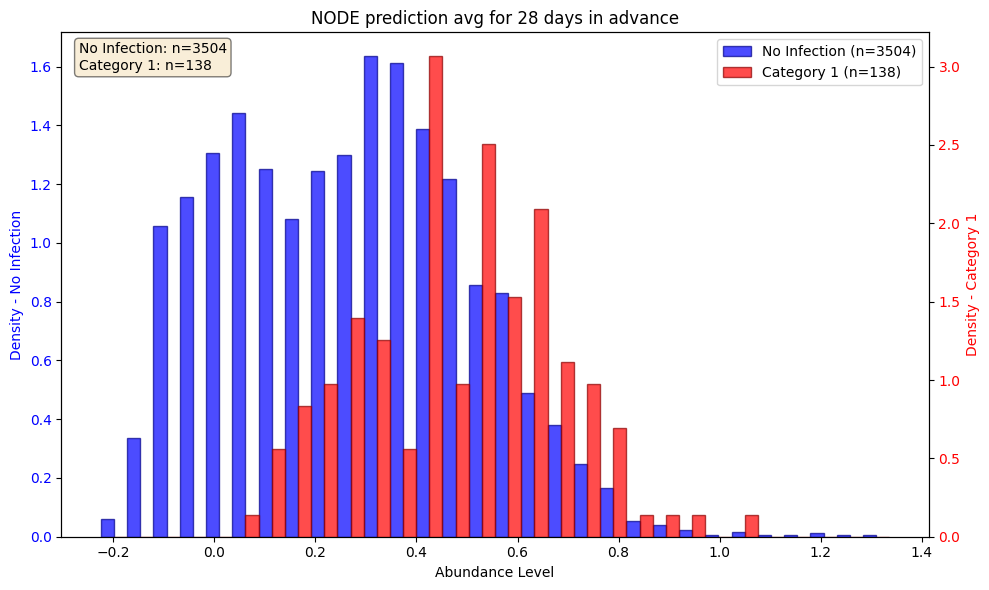

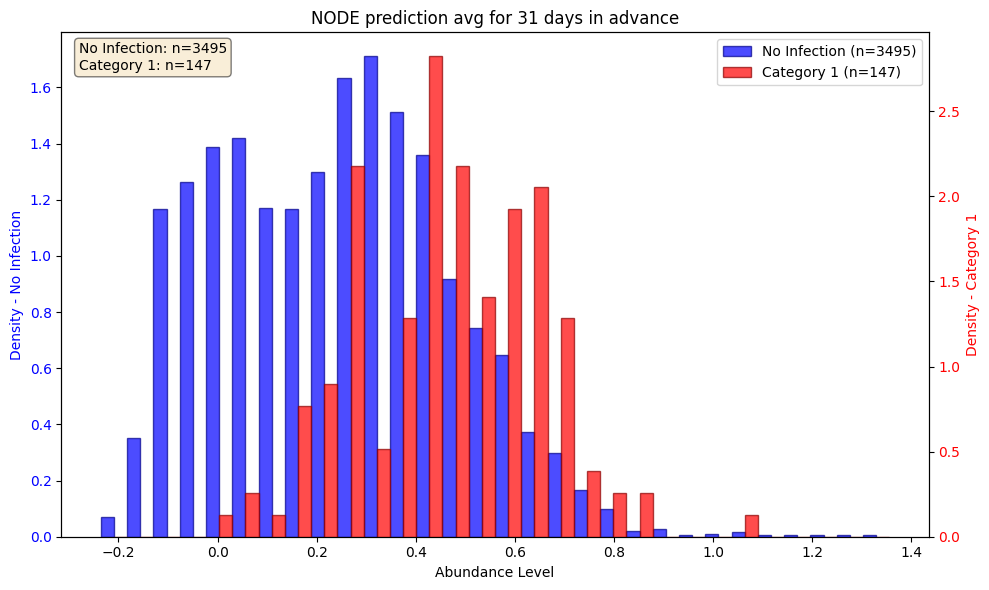

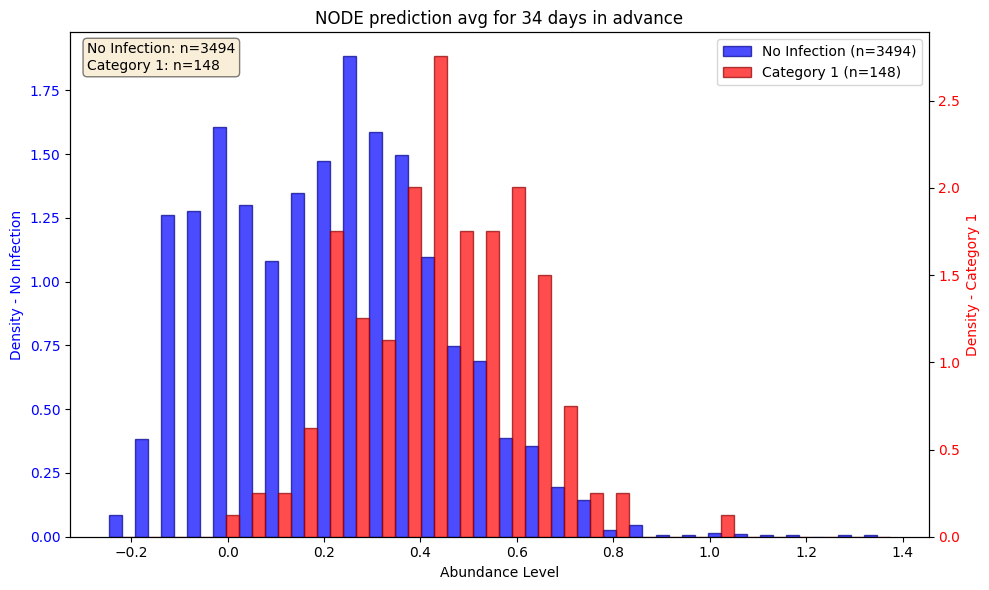

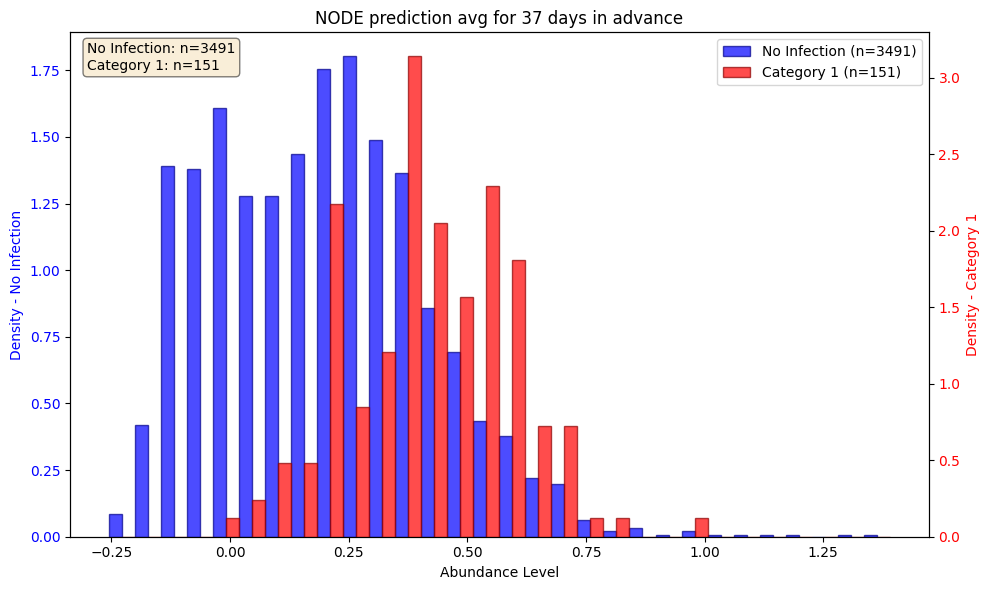

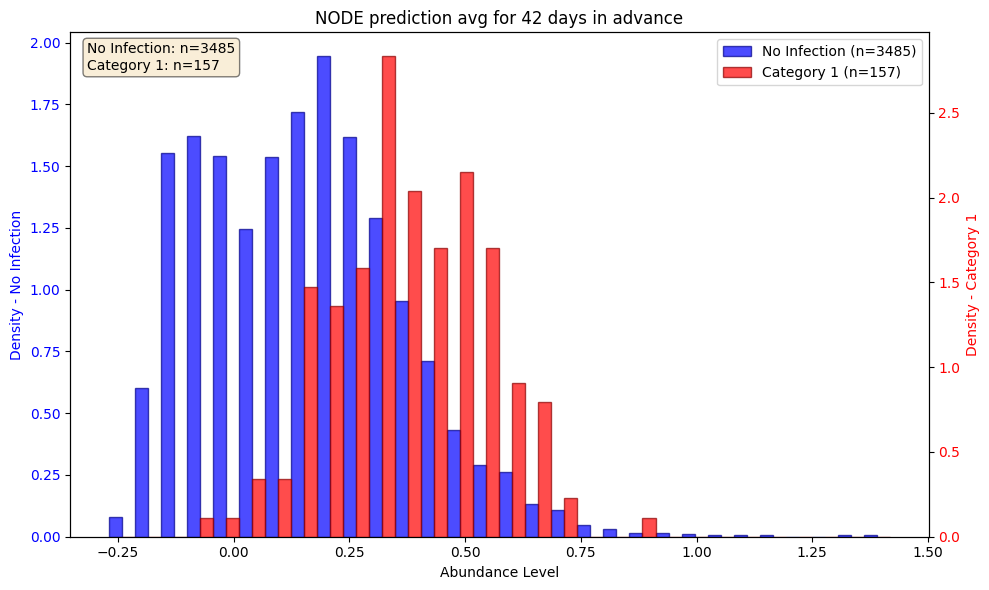

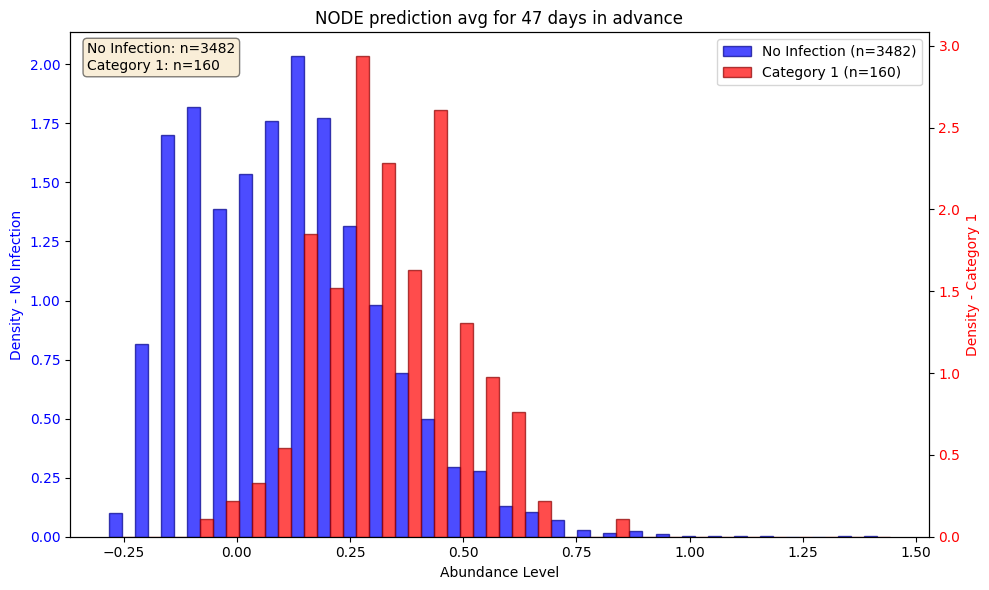

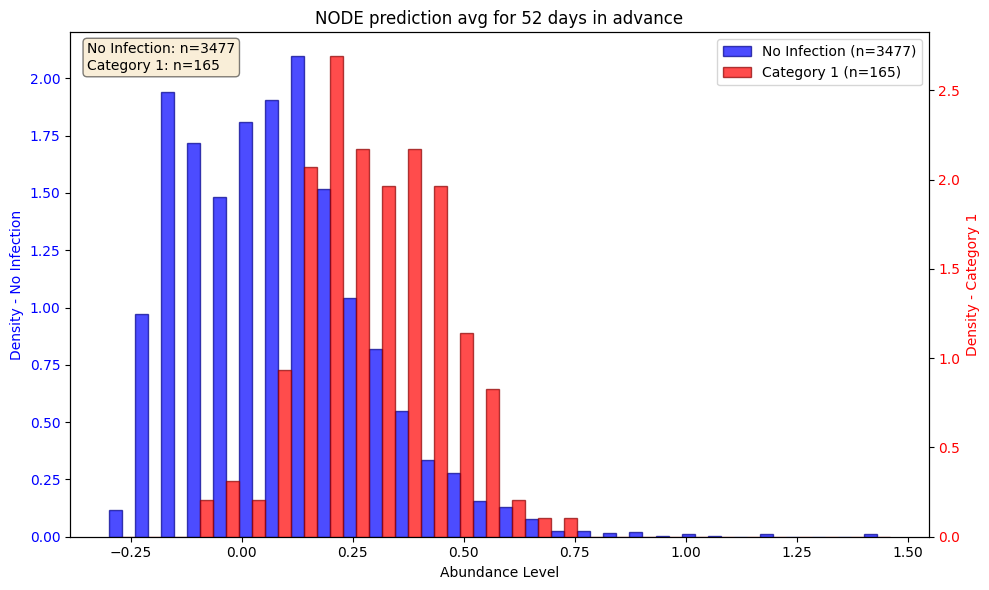

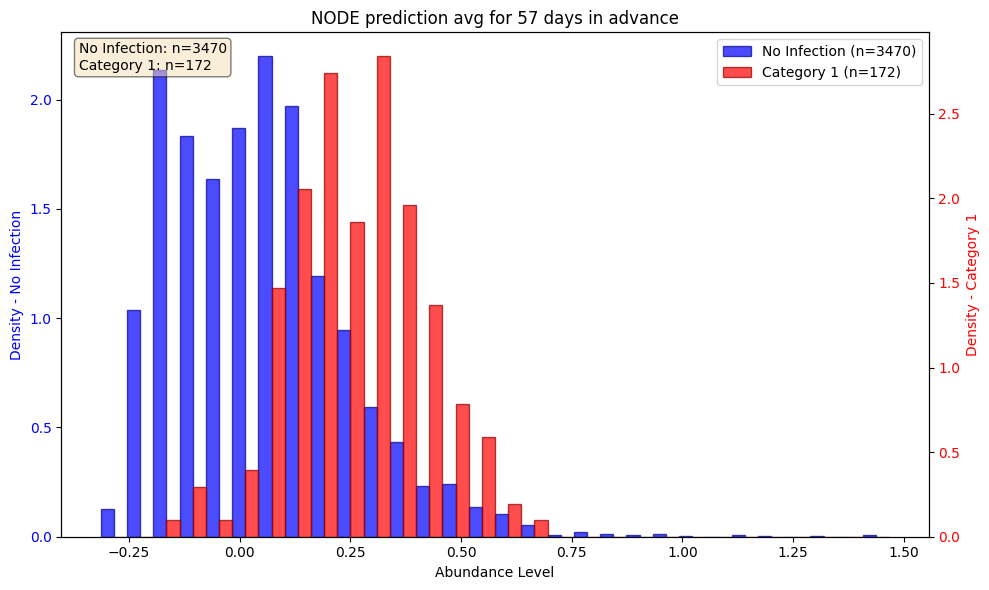

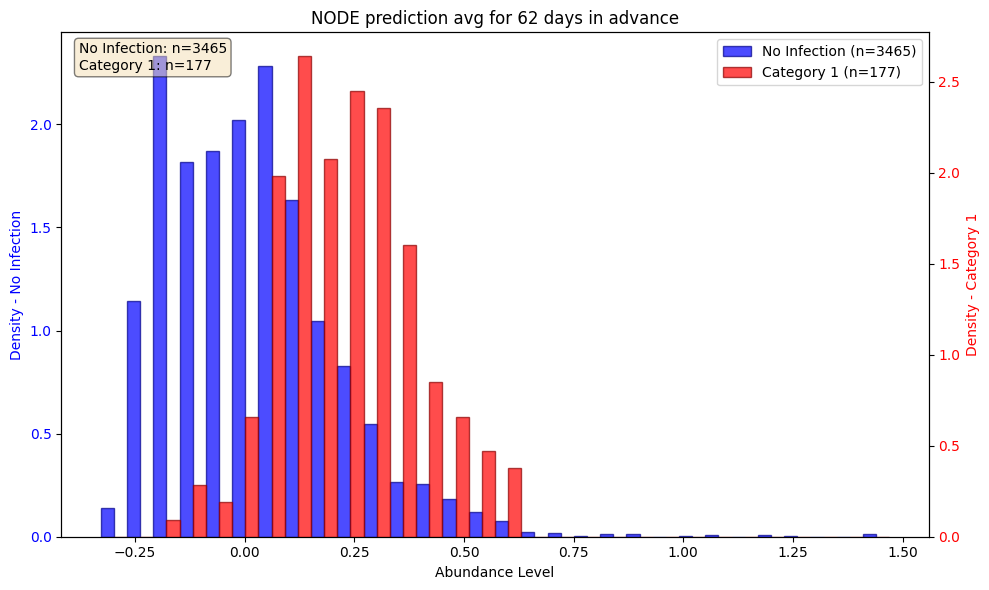

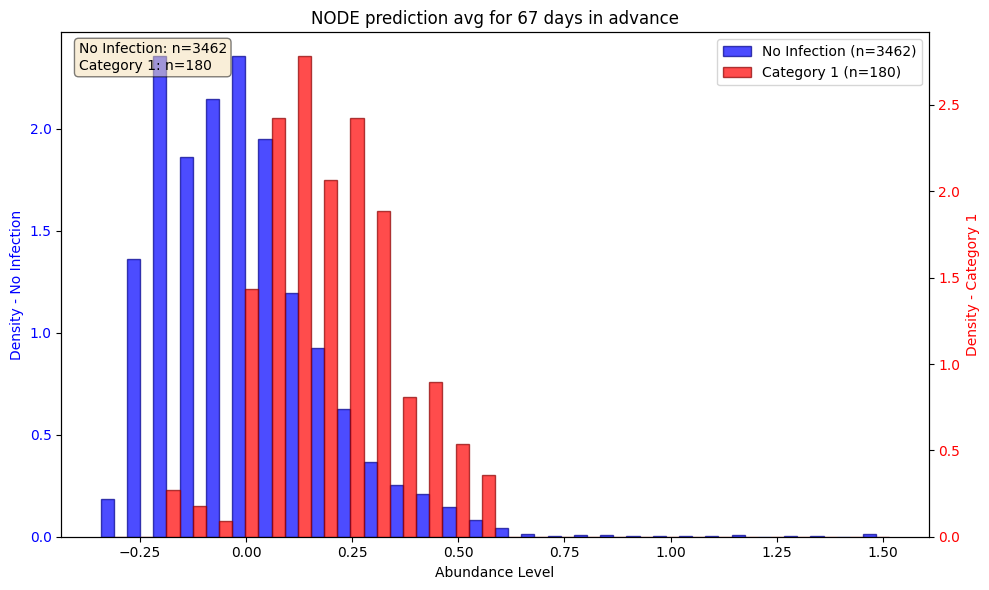

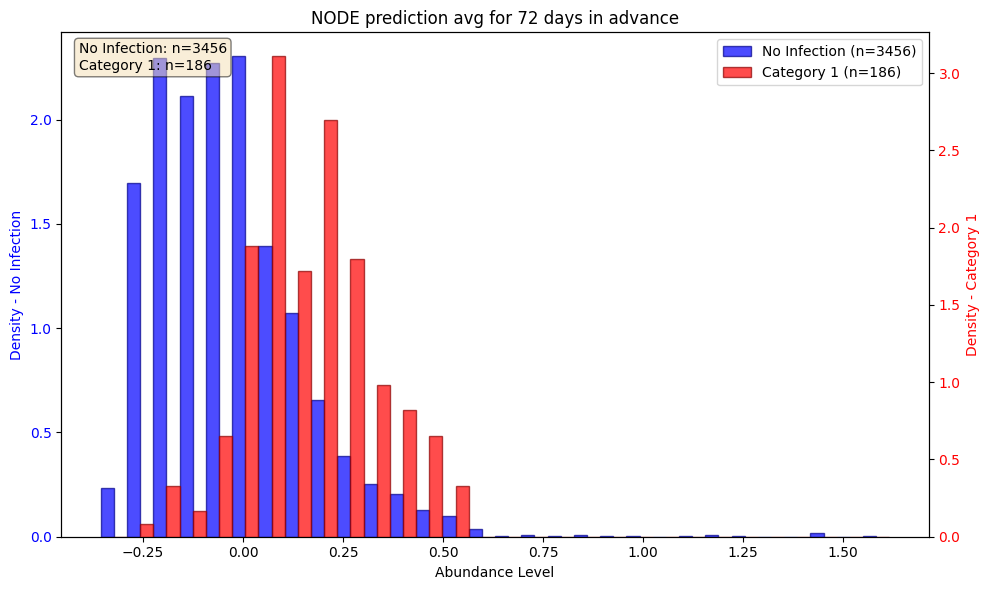

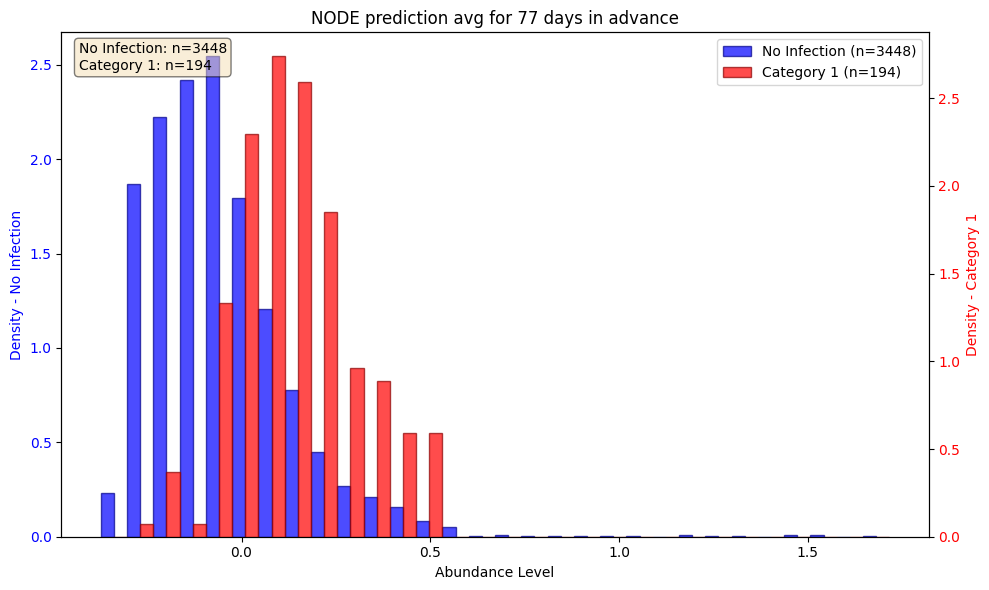

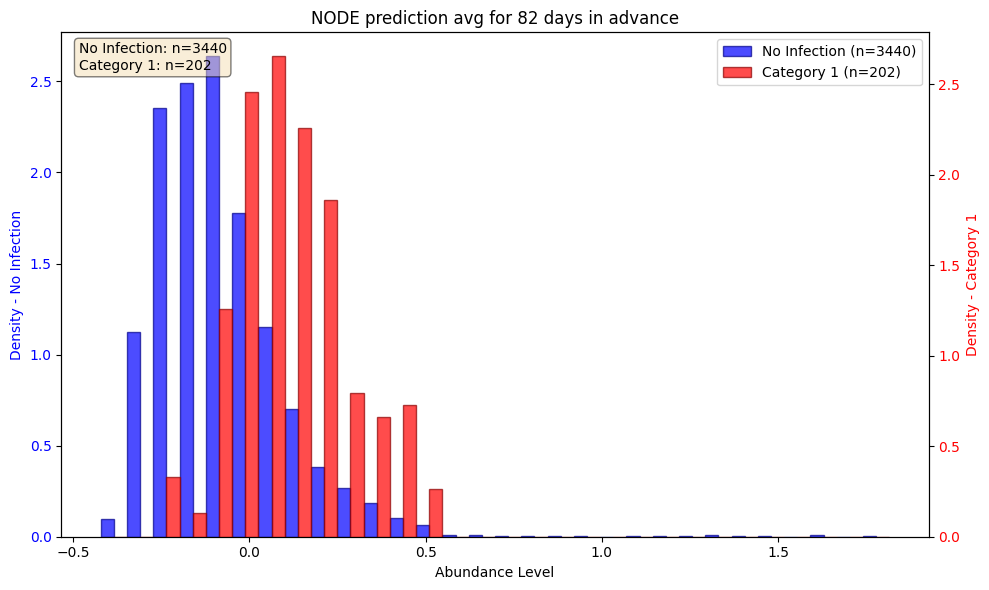

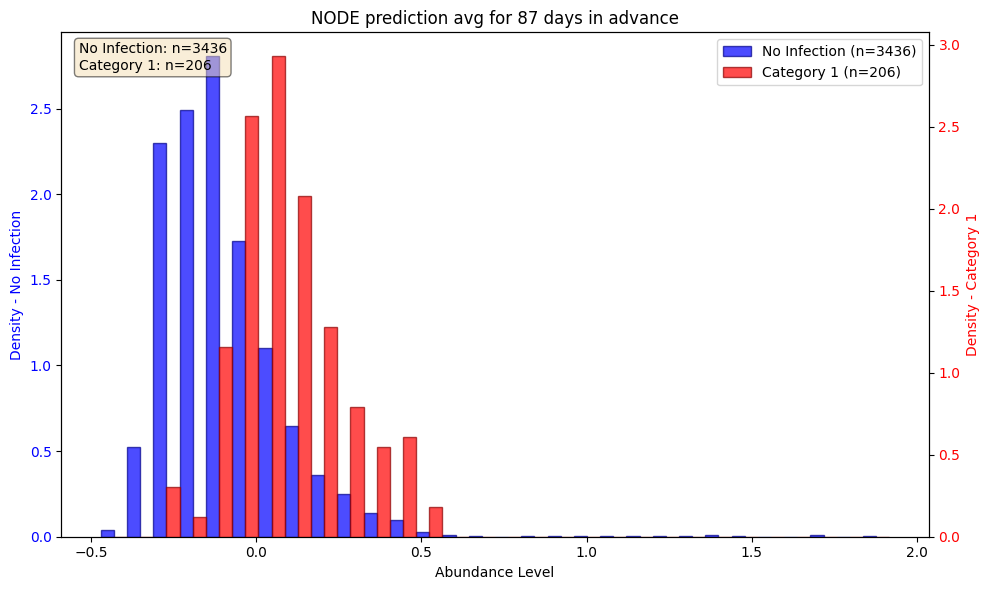

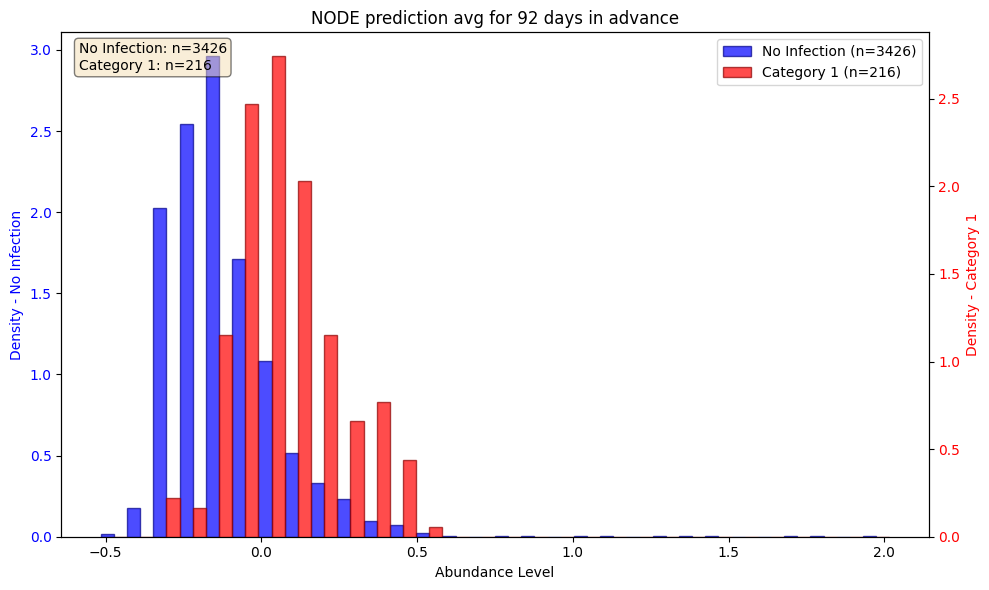

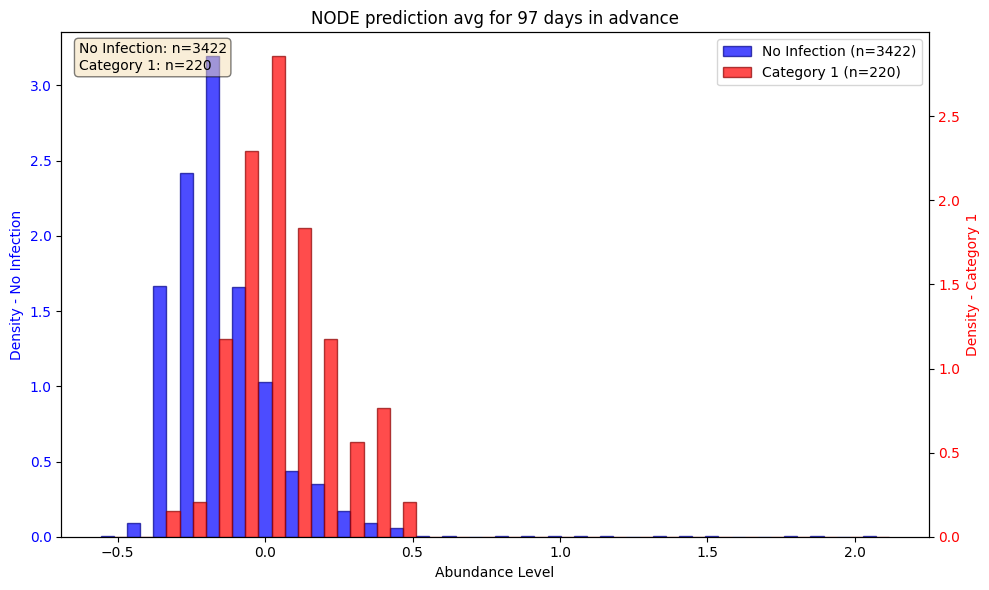

In [6]:
for i in list(range(10, 40, 3)) + list(range(42, 100, 5)):
    abundance_predictions = node_dict[i]
    
    # Separate data by category
    cat0_data = abundance_predictions[abundance_predictions[:, 1] == 0, 0]
    cat1_data = abundance_predictions[abundance_predictions[:, 1] == 1, 0]
    
    n_cat0 = len(cat0_data)
    n_cat1 = len(cat1_data)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Create shared bins for both categories
    all_data = np.concatenate([cat0_data, cat1_data])
    bins = np.histogram_bin_edges(all_data, bins=30)
    bin_width = bins[1] - bins[0]
    
    # Calculate histogram values for both categories
    counts0, _ = np.histogram(cat0_data, bins=bins, density=True)
    counts1, _ = np.histogram(cat1_data, bins=bins, density=True)
    
    # Plot category 0 bars shifted to the left
    ax1.bar(bins[:-1] - bin_width/4, counts0, width=bin_width/2, 
            color='blue', alpha=0.7, label=f'No Infection (n={n_cat0})', 
            edgecolor='darkblue', align='edge')
    ax1.set_ylabel('Density - No Infection', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Create second y-axis for category 1
    ax2 = ax1.twinx()
    # Plot category 1 bars shifted to the right
    ax2.bar(bins[:-1] + bin_width/4, counts1, width=bin_width/2, 
            color='red', alpha=0.7, label=f'Category 1 (n={n_cat1})', 
            edgecolor='darkred', align='edge')
    ax2.set_ylabel('Density - Category 1', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Add title and x-label
    ax1.set_xlabel('Abundance Level')
    ax1.set_title(f'NODE prediction avg for {i} days in advance')
    
    # Add sample counts as text on the plot
    ax1.text(0.02, 0.98, f'No Infection: n={n_cat0}\nCategory 1: n={n_cat1}', 
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()

In [ ]:
def get_infection_prediction_data(model, test_df, index_of_taxa = 2, 
                               number_of_taxa = 'reduced', method = 'euler', 
                               aggregate_statistic = 'mean', convert_to_relative_abundances = False, range_days = 7):
    
    print('computing infection predictions...')
    
    if index_of_taxa == 2:
        infections_df = df_bacilli_infections
        name_of_class = 'Bacilli'
    if index_of_taxa == 9:
        infections_df = df_gammaproteobacteria_infections
        name_of_class = 'Gammaproteobacteria'
    
    # Dictionary to store predictions for each range (1 to 100 days)
    predictions_by_range = {range_days: [] for range_days in range(1, 101)}
    
    for patient_id in test_df['PatientID'].unique():
        model.patient_id = patient_id
        # get the trajectory data for patient_id's timeline
        t_preds, t_true, y_trues, true_indices = MyModels.get_data(test_df, patient_id, number_of_taxa = number_of_taxa)
        print(patient_id)
        for i in range(len(t_true)-1):
            # start of predicted trajectory
            t_start = t_true[i]
            y0 = y_trues[i]
            t_end = t_start + 100  # Predict 100 days ahead
            t_preds = torch.linspace(t_start, t_end, int((t_end-t_start)*3)).to(device)
            
            # Compute NODE prediction once for 100 days
            y_pred_trajectory = odeint(model, y0, t_preds, method=method)
            
            # if the model is glv
            if convert_to_relative_abundances:
                y0 = torch.nn.functional.normalize(torch.clamp(y0, min=0), p=1, dim=0)
                y_pred_trajectory = torch.nn.functional.normalize(torch.clamp(y_pred_trajectory, min=0), p=1, dim=1)

            taxa_pred_trajectory = y_pred_trajectory[:, index_of_taxa]
            actual_infection_times = list(infections_df[infections_df['PatientID']==patient_id]['DayRelativeToNearestHCT'])
            t_start_cpu = t_start.cpu().numpy()
            initial_bacilli_abundance_level = np.float64(y0[index_of_taxa].cpu().detach().item())
            
            # For each range from 1 to 100 days
            for range_days in range(1, 101):
                # Determine which time points fall within this range
                t_preds_cpu = t_preds.cpu().numpy()
                mask = (t_preds_cpu >= t_start_cpu) & (t_preds_cpu <= t_start_cpu + range_days)
                taxa_pred_in_range = taxa_pred_trajectory[mask]
                
                # Compute aggregate statistic for this range
                if aggregate_statistic == 'max':
                    taxa_pred_summary_abundance_level = np.float64(torch.max(taxa_pred_in_range).item())
                elif aggregate_statistic == 'mean':
                    taxa_pred_summary_abundance_level = np.float64(torch.mean(taxa_pred_in_range).item())
                
                # Check if infection occurred within this range
                actual_infection = int(any((t_start_cpu <= t < t_start_cpu + range_days) for t in actual_infection_times))
                
                predictions_by_range[range_days].append([
                    taxa_pred_summary_abundance_level, 
                    actual_infection, 
                    initial_bacilli_abundance_level
                ])
    
    # Convert lists to numpy arrays and remove NaN rows
    for range_days in range(1, 101):
        print(range_days)
        abundance_predictions = np.array(predictions_by_range[range_days])
        # remove rows with NAN
        abundance_predictions = abundance_predictions[~np.isnan(abundance_predictions).any(axis=1)]
        predictions_by_range[range_days] = abundance_predictions
    
    print('done computing infection predictions')
    return predictions_by_range

node_dict = make_infection_predictions(node_model, test_df)
